# Subject
Our goal is to analyze this dataset, to offer a visualization of the housing prices, and to try to predict the price of a house at a single property level regarding as many features as possible (regression problem).

## The Dataset
The dataset represents the prices of houses in californian districts, regarding several numrical and categorical features. It was found at: https://raw.githubusercontent.com/ageron/handson-ml2/master/, during my training and reading of the book: Hands-on Machine Learning with SKlearn, TensorfFlow, Keras, by Aurélien Géron, which I highy recommend.

## Basic methodology
In a first time, we will try to visualize some key metrics about the dataset and each feature (EDA and viz) using klib, pandas and pandas-profiling. Correlations will also be checked.

In a second time, we will try to engineer the features we have at our disposal in the best way possible, with self-made pipelines.

In a third time, we will use those features to train different types of models (regressors) and find the ones that are performing the best, and then fine-tune them (accuracy measure: RMSE).

In a fourth time, we will try to apply some ensemble learning and some stacking about those models to improve their performance.

The librairies we will use are:
- pandas, numpy, seaborn, matplotlib for the basics
- pandas-profiling and klib for the EDA
- sklearn, xgboost and DESlib for the machine learning model training.


## Suggested improvements: 
- Clean-out outliers.

- Try with other scalers or imputers.

- Try without the median income (highest correlated feature).

- Try to measure accuracy with MAE (good for outliers) and r2.

- Try keeping only the most important features (with RandomForest.feature_importance).

- Try applying PCA for dimensonality reduction.

- Try find better parameters (randomized search instead of Gridsearch).

- Try stacking (once DESlib enables it).

- Try a deep learning neural network to compare the accuracies, and include it in the ensemble model.

# Imports

In [1]:
# Data manipulation
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

#import pandas_profiling
from pandas_profiling import ProfileReport
#import json
#import csv
import klib

#import tqdm to plot progress bar when training models
from tqdm.notebook import tqdm
from time import sleep

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#In-depth Visualizations
#import plotly
#import plotly.graph_objs as go
#import plotly.offline as ply
#plotly.offline.init_notebook_mode(connected=True)
#
#import cufflinks as cf
#cf.go_offline(connected=True)
#cf.set_config_file(theme='white')

# Autoreload extension
#if 'autoreload' not in get_ipython().extension_manager.loaded:
#    %load_ext autoreload
#    
#%autoreload 2

#Machine Learning imports
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn                    import metrics, svm
from sklearn.linear_model           import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import preprocessing
from sklearn import manifold

#Advanced Ensemble and Stacking techniques
# Example of DCS techniques
from deslib.dcs import OLA
from deslib.dcs import MCB
# Example of DES techniques
from deslib.des import KNORAE
from deslib.des import DESP
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.static import StackedClassifier

# Data collection

Here we are going to define a function that gets the data on the github repository.

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
#importing data in dataframe
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
#Load and look at first lines
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Here we are going to split the training and test set before looking at it, to avoid data snooping.
Note that the use of KfoldStratifiedSplit is notnecessary, as we will use the Kfold cross validation methodology later

In [6]:
#split data to avoid data snooping
#KFoldStratifiedSplit is not necessary here, as we will use K-fold cross validationwhen evaluating our model
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Exploratory Data Analysis and visualization

## Classical EDA

In this part, we will have a look at our data using the basic EDA tools from pandas (head, describe, info,... )

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Here we look at the only categorical attribute.

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


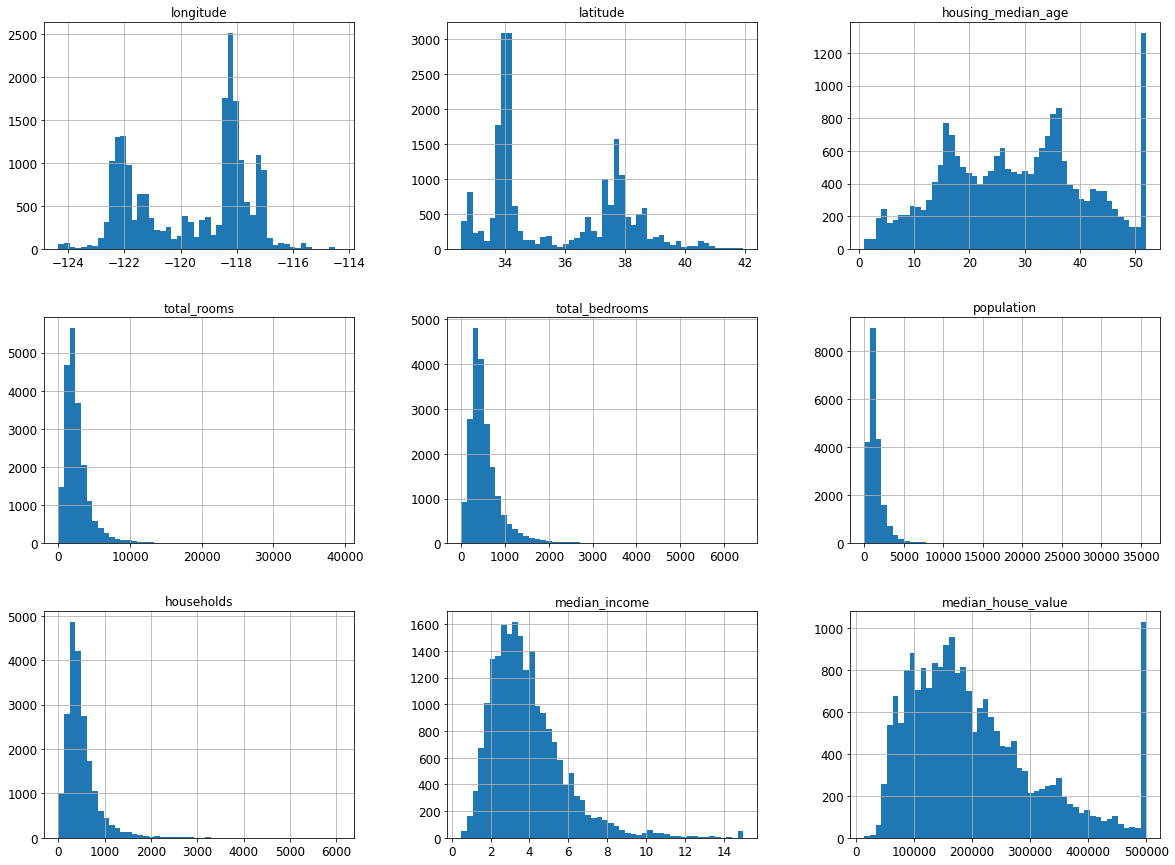

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Comments about the histogramms:
- The median income, the median house value and the housing median age look capped.
- The attributes have very different scales.
- Some attributes are tail-heavy (outliers)

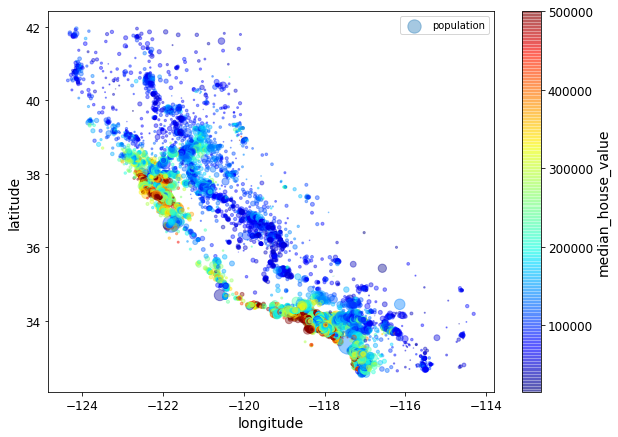

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()


## EDA with Klib and pandas-profiling

Here we are going to generate an in-depth report about our datasets, in order to look easily at each feature individually, and access some key information about it.

In [12]:
#generating report with pandas-profiling
profile=ProfileReport(housing
                                       ,minimal=True
                                      # ,explorative=True
                                       #,check_correlation = True
                                        ,title="Housing EDA"
                                      )
profile

Drill down into the missing values:

GridSpec(6, 6)

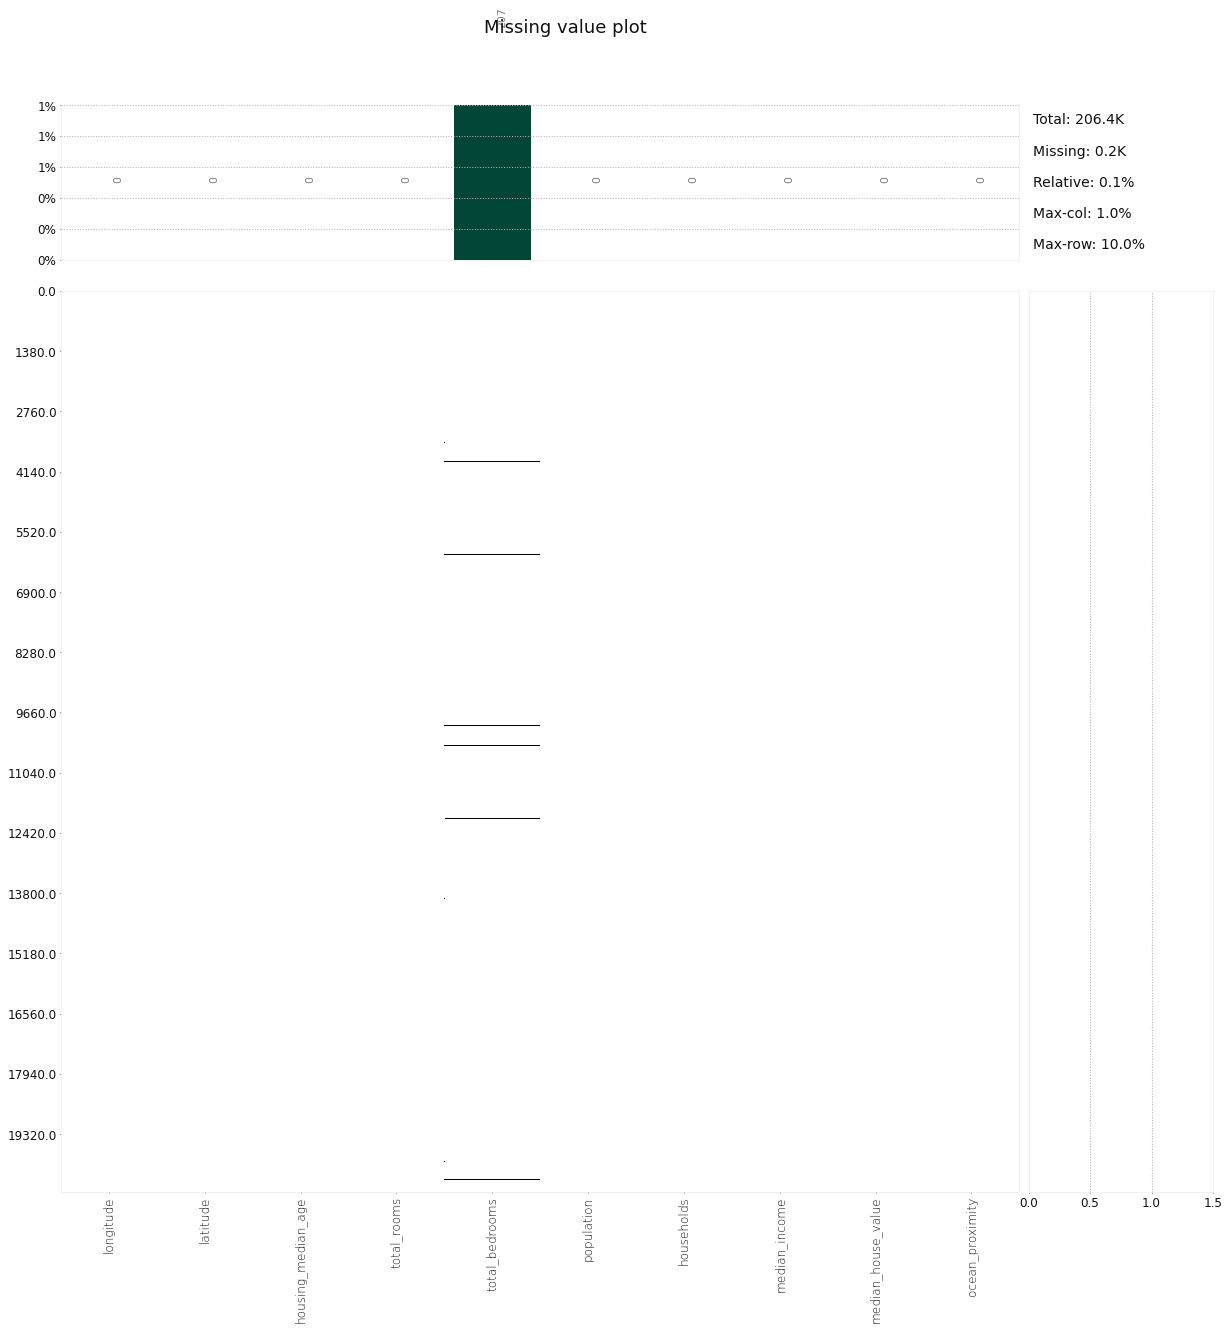

In [13]:
#Missing values with klib:
klib.missingval_plot(housing)

Looking at our target:

C:\Users\louis\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\louis\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_house_value', ylabel='Density'>

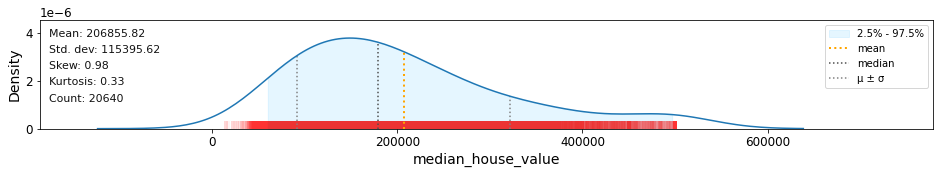

In [14]:
#Visualising distribution of the target feature
klib.dist_plot(housing['median_house_value'])

Categorical plot of the only categorical feature:

GridSpec(6, 1)

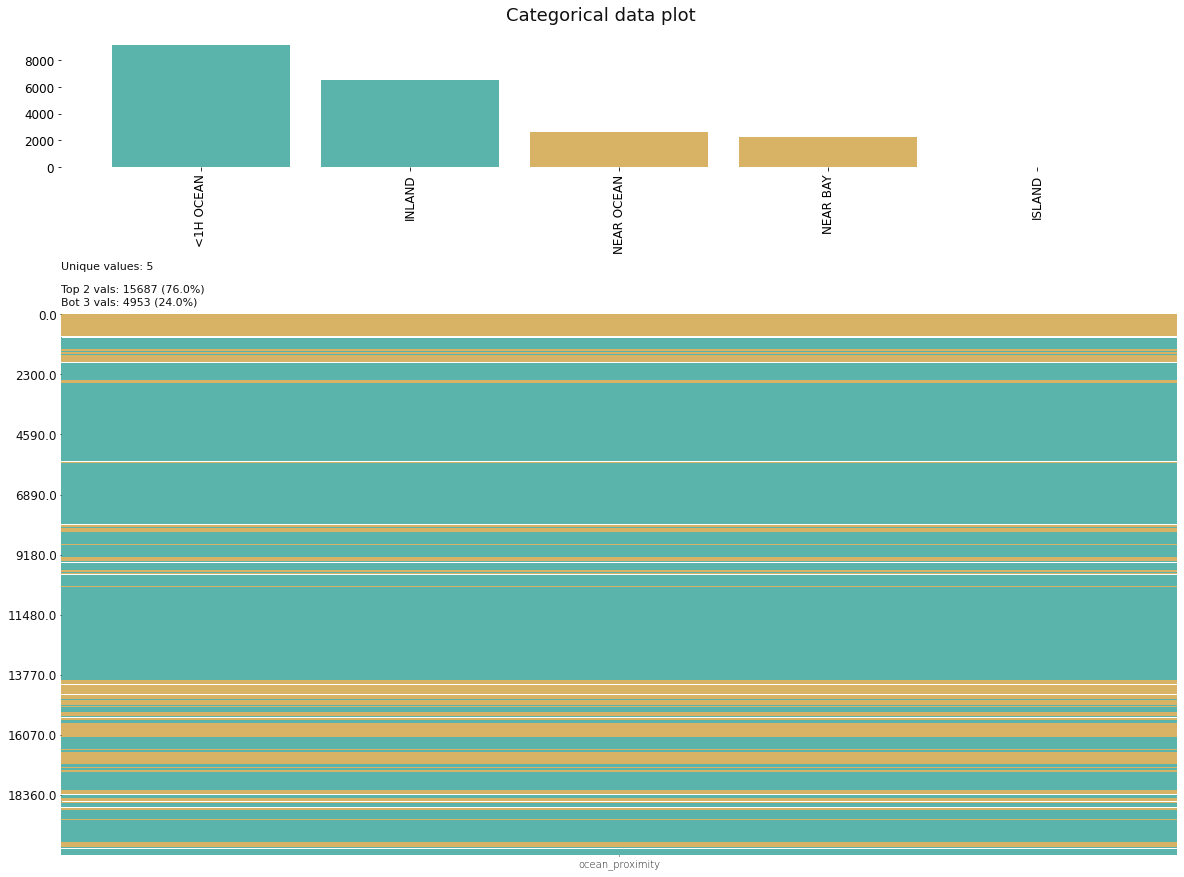

In [15]:
#Visualising categorical features
klib.cat_plot(housing, figsize=(20, 15))

## Correlation analysis

In this part we will look at the correlation between our features, espeacially with our target feature. This is done in order to find obvious relationships in the data.
Highly correlated feature might yield solutions that are wildly varying and possibly numerically unstable. 
In this example, we will use the classical Pearson correlation.

In [16]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

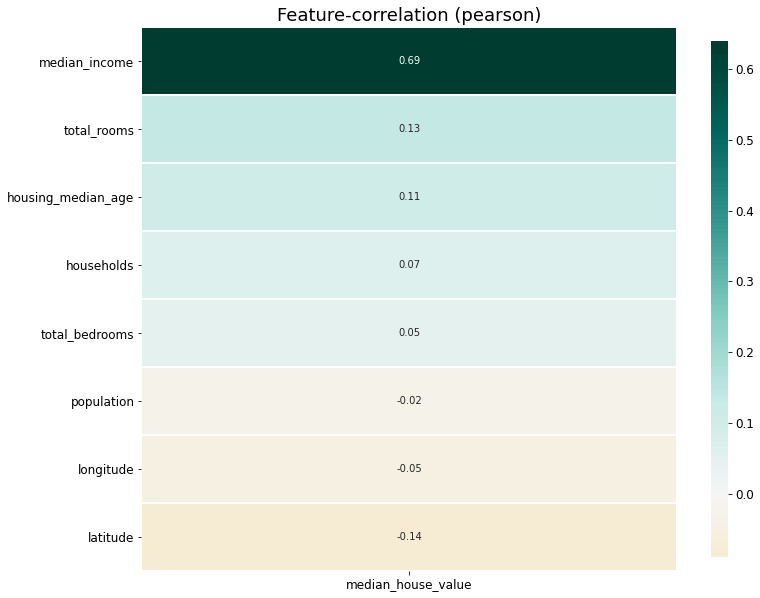

In [17]:
#Same but with klib
klib.corr_plot(housing, target="median_house_value")

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

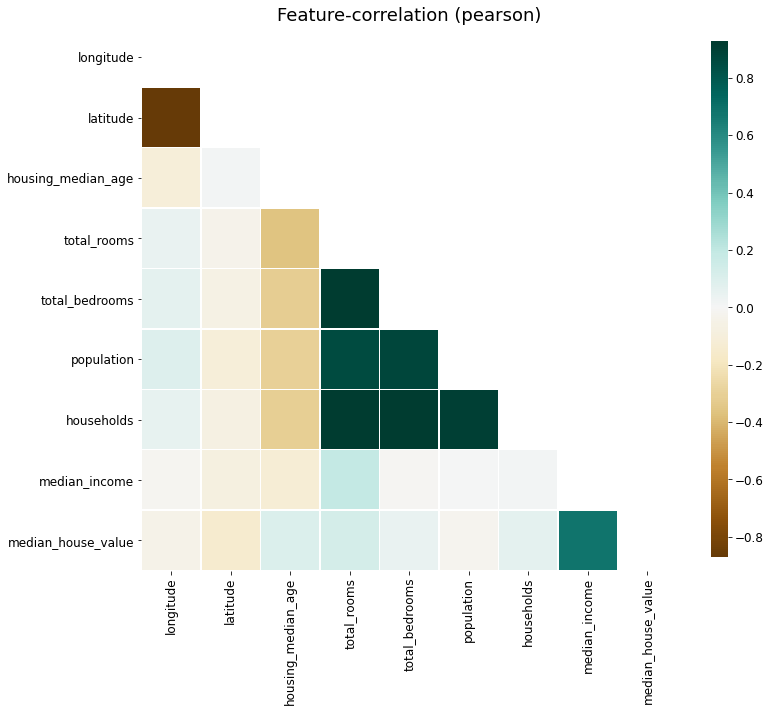

In [18]:
#See all correlations
klib.corr_plot(housing, annot=False)

Here we will have a better look at the most correlated features with our target feature. To do so, We will look at a pair plot of the three features, and then each individual feature that looks interesting in the pairplot.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

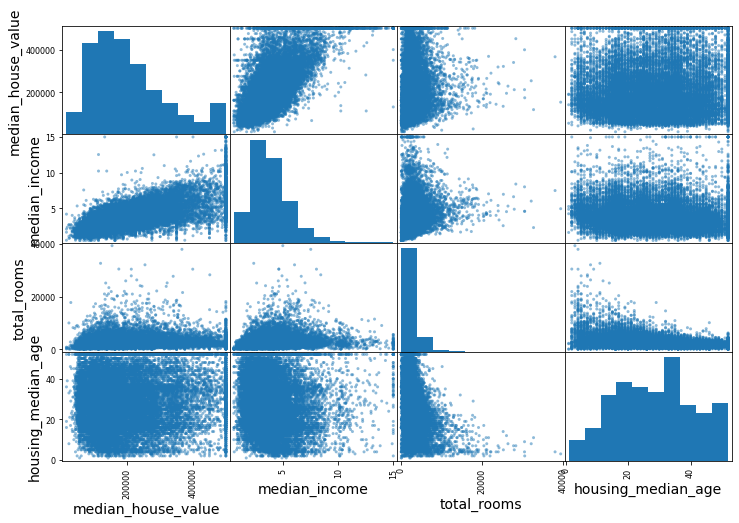

In [19]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

As said before, we will look more in-depth at the median income as it seems highly correlated in the par-plot.

(0.0, 16.0, 0.0, 550000.0)

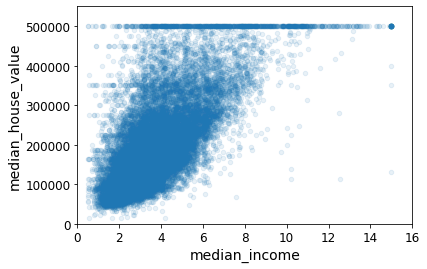

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

For the median income, the correlation is indeed strongly positive, and we see that the data is capped. Also, straight lines seem to be in the data (clearly visible at 350000), maybe representing errors in the data aquisition.


After the correlation checks, we will keep all the features in order to see what happens. An alternative would be to get rid of the median income feature.

# Feature engineering

## Data cleaning

Here we clean the duplicate lines and the constant columns. (It was not necessary in this analysis). From here on, we will work on the train_set, instead of the full housing set.

In [21]:
#Cleaning code, but not necessary here
train_set=klib.data_cleaning(train_set)

Shape of cleaned data: (16512, 10)Remaining NAs: 0

Changes:
Dropped rows: 0
     of which 0 duplicates. (Rows: [])
Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 0.06 MB (-4.32%)



## Creating smart features

Here we are going to define some new "smart" features. This is done by guessing what might be a good indicator about our problem, and just general thinking about the features wew already have.

In [22]:
train_set["rooms_per_household"] = train_set["total_rooms"]/train_set["households"]
train_set["bedrooms_per_room"] = train_set["total_bedrooms"]/train_set["total_rooms"]
train_set["population_per_household"]=train_set["population"]/train_set["households"]

Also, after checking the new correlations with the newly created features, we defintely see more impact of those, which is great news.

Then we are going to create our separated input feature matrix and target label matrix:

In [23]:
housing = train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = train_set["median_house_value"].copy()

In [24]:
housing.shape

(16512, 12)

## Full pipeline as learned, that handles categorical feature

In a first time, we will create a pipeline that takes care of the numerical attributes.
For this, we need two steps: 
- Imputing values where there were missing values. For that we will use the median, but other ways might be tried out later to improve the model.
- Scaling the features. For that we will use the standard scaler (the normalization scaler) as it handles outliers well (that we did not remove here).

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
#how to handle each numerical feature
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #imputing median values
        ('std_scaler', StandardScaler()), #Scaling dat
    ])

Here we combine the first pipeline into the final one, that handles the categorical features separately.
To handle those features, we will use the one hot encoder.

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#full pipeline
housing_num = housing.drop("ocean_proximity", axis=1) #only numerical attributes
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), #One hot encoder for categories
    ])

housing_prepared = full_pipeline.fit_transform(housing)

Housing prepared is our final dataset, ready for modelling:

In [27]:
housing_prepared.shape

(16512, 16)

# Select and train a model 

## Linear regression

In a first time, we will try linear regressions, with and without regularization.

### Plain linear regression

In [28]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

We will try to evaluate in thsi case with two metrics: RMSE and MAE, but in the following of the notebook, we will stick with RMSE.

In [29]:
from sklearn.metrics import mean_squared_error
#Trying both measures
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67593.20698718211

In [30]:
from sklearn.metrics import mean_absolute_error
#MAE
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

48785.15963458422

### Linear regression with regularization (ElasticNet, l0 and l1 norms)

In [31]:
#As an example here, not really useful
from sklearn.linear_model import ElasticNet
elastic= ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic.fit(housing_prepared, housing_labels)
housing_predictions = elastic.predict(housing_prepared)
reg_mse = mean_squared_error(housing_labels, housing_predictions)
reg_rmse = np.sqrt(lin_mse)
reg_rmse

67593.20698718211

Regularization doesn't seem to affect us here, as we are not trying to use the K-fold cross validation, or evaluating on the test set. But let's try another model.

## Trying Decision Trees

### Decision tree training

In [32]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [33]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The Decision Tree is clearly overfitting the data. In the section, we will use K-fold cross validation to evaluate the tree model (and all other models), and compare it to the linear regression model.

Here we will plot an example tree to understand how it works, with max_depth=3:

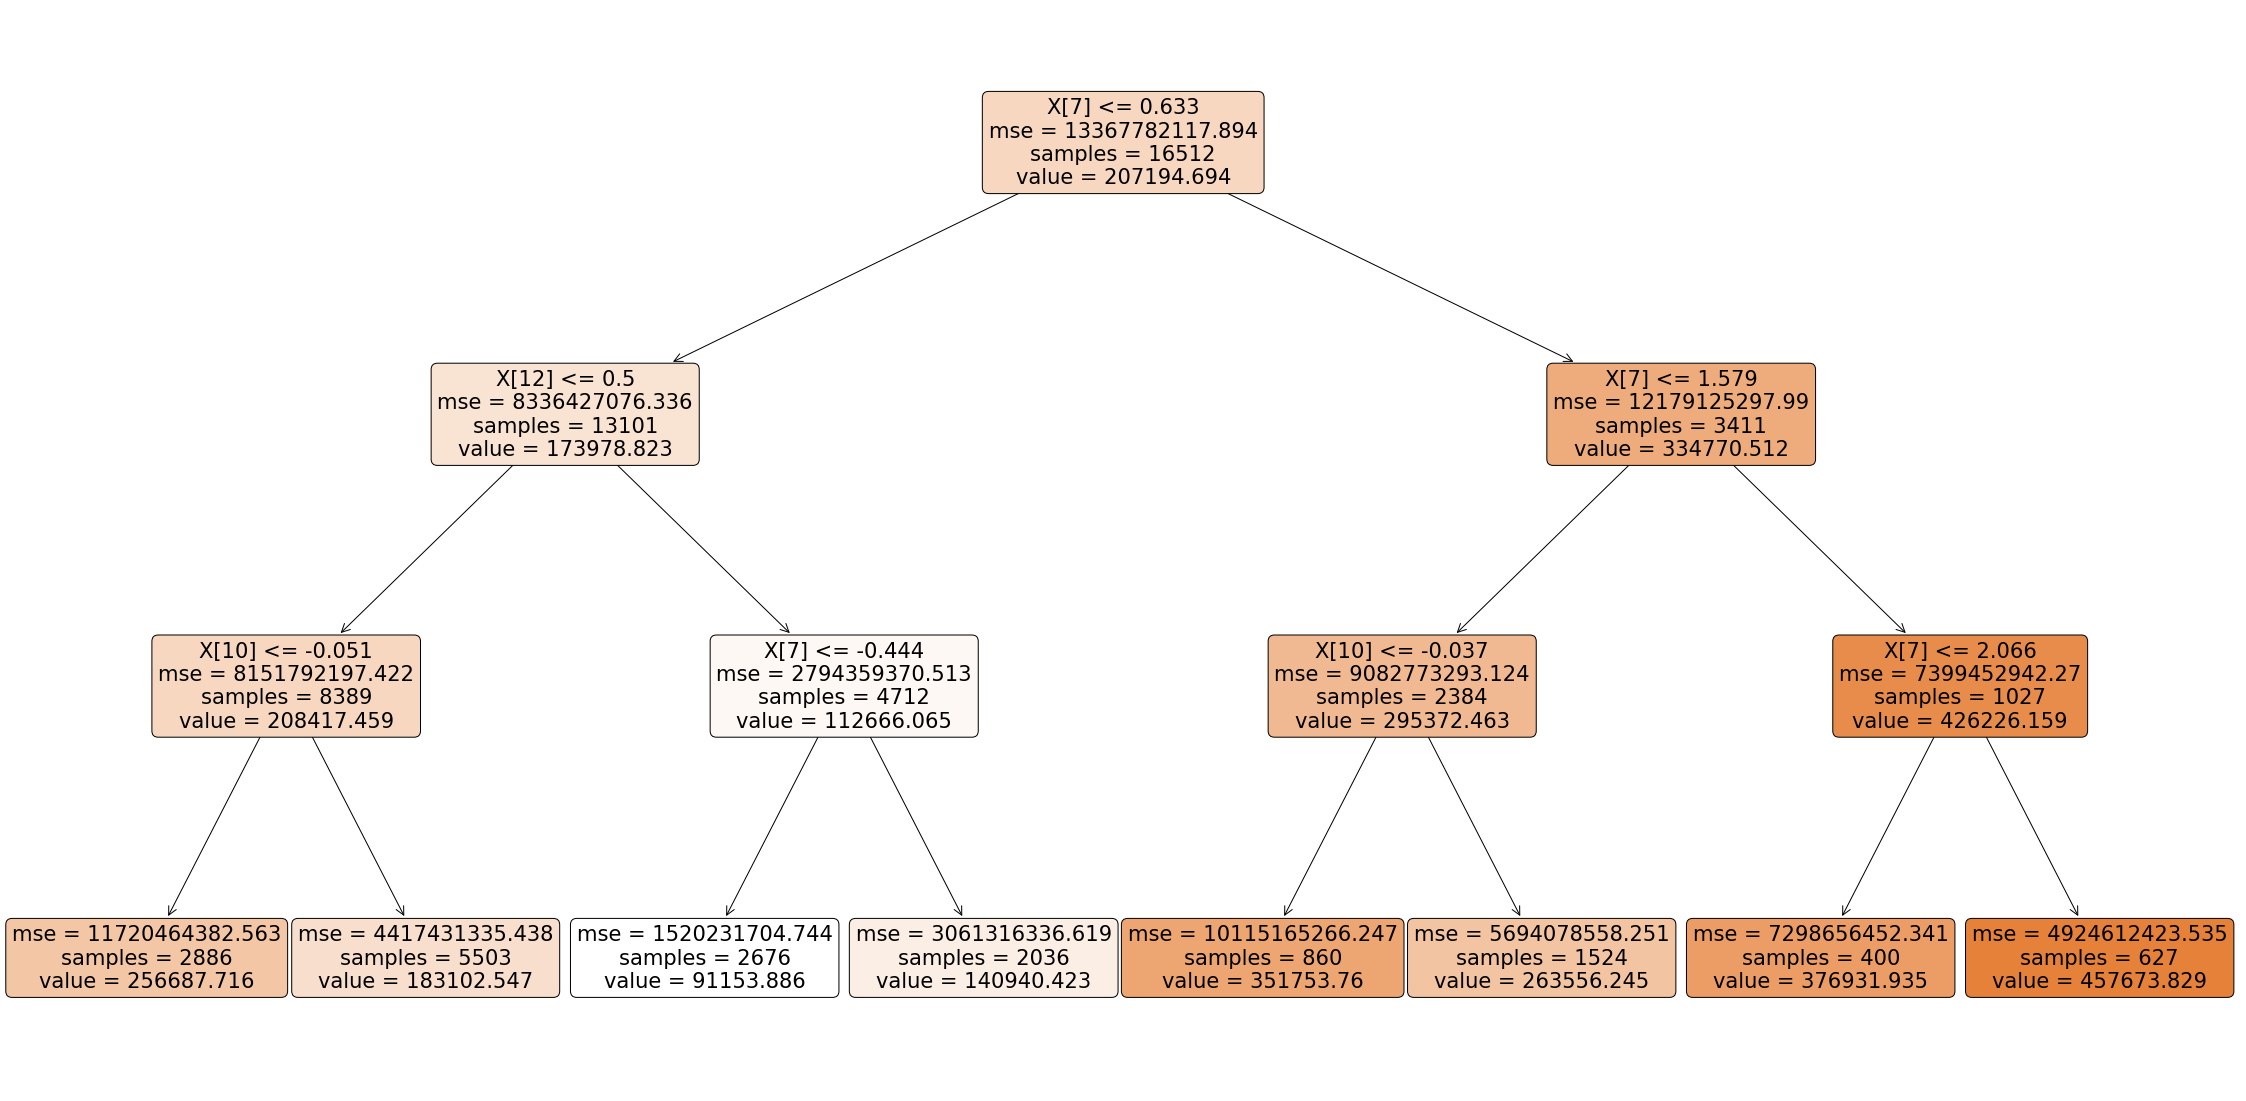

In [34]:
tree_reg_test = DecisionTreeRegressor(max_depth= 3, random_state=42)
tree_reg_test.fit(housing_prepared, housing_labels)

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))  
_ = tree.plot_tree(tree_reg_test,
             filled=True, fontsize=21, rounded = True)
plt.show()

### Comparing Decision Trees and Linear Regression

Evaluating decision tree using kfold:
(NAB from stackoverflow: Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root).


In [35]:
from sklearn.model_selection import cross_val_score
#Measuring accuracy using cross validation
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
#Measuring cross validation scores for decision trees
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [65305.14038488 71332.10467463 67820.84411318 72125.72865001
 73512.07656658 66384.61932395 66954.26621705 67558.95731811
 65234.24602669 70976.63920147]
Mean: 68720.46224765718
Standard deviation: 2846.375971357991


Comparing with linear regression to be sure:

In [37]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65000.67196139 70960.55971997 67122.63950272 66089.63203105
 68402.54408579 65266.34889292 65218.78390748 68525.46552466
 72739.87527402 68957.34274993]
Mean: 67828.38636499297
Standard deviation: 2468.090905979022


Bad scores for decision trees and linear regressions, they most likely underfit the data. We will now try more complex models to avoid underefitting.

## Random Forest attempt

In this section, we will train a random forest, then fine-tune its parameters using GridSearch.

### Random Forest Training

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     49679.284049
std       2021.064764
min      46877.379953
25%      47883.447965
50%      49745.868994
75%      51261.238008
max      52766.073712
dtype: float64

Here we will try to look at the feature importance, to see which ones have the most impact:

In [40]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

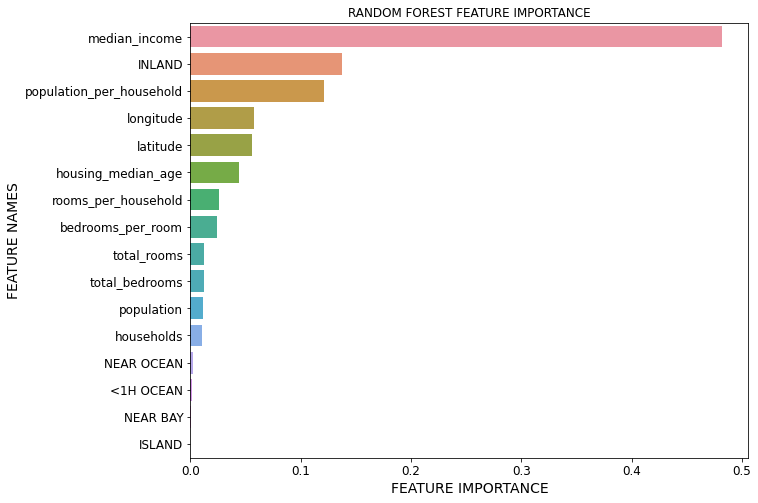

In [41]:
import matplotlib.pyplot as plt
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs

plot_feature_importance(forest_reg.feature_importances_,attributes,'RANDOM FOREST ')

Note that the engineered feature "Rooms per household" contribues way more then the initial "total bedrooms" feature.

### Grid search to fine tune the RF

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 100], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [43]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 100}

In [44]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [45]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63707.91621960306 {'max_features': 2, 'n_estimators': 3}
54791.91896551806 {'max_features': 2, 'n_estimators': 10}
52744.45397679001 {'max_features': 2, 'n_estimators': 30}
51624.295562982836 {'max_features': 2, 'n_estimators': 100}
60293.33063224703 {'max_features': 4, 'n_estimators': 3}
52067.431783092994 {'max_features': 4, 'n_estimators': 10}
49982.953752847134 {'max_features': 4, 'n_estimators': 30}
49425.8437231654 {'max_features': 4, 'n_estimators': 100}
57665.997728822345 {'max_features': 6, 'n_estimators': 3}
51031.2269535148 {'max_features': 6, 'n_estimators': 10}
49423.56664898021 {'max_features': 6, 'n_estimators': 30}
48971.65186653001 {'max_features': 6, 'n_estimators': 100}
58918.027053210324 {'max_features': 8, 'n_estimators': 3}
51931.94694875147 {'max_features': 8, 'n_estimators': 10}
49967.474159294215 {'max_features': 8, 'n_estimators': 30}
49373.989708847046 {'max_features': 8, 'n_estimators': 100}
62053.640641501246 {'bootstrap': False, 'max_features': 2, 'n_estim

## XGBoosting attempt

In this section, we will train a boosting algorithm, then fine-tune its parameters using GridSearch.

### XGBoost training

In [46]:
boosting = xgb.XGBRegressor()
boosting.fit(housing_prepared, housing_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(boosting, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     47256.548331
std       1800.859990
min      44462.908947
25%      45880.157456
50%      47508.884212
75%      48067.967031
max      49975.912278
dtype: float64

### Grid search to fine tune XGB

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.01,0.05,0.1], #so called `eta` value
              'max_depth': [6,10,20],
              #'min_child_weight': [11],
              #'silent': [1],
              #'subsample': [0.8],
              #'colsample_bytree': [0.7],
              'n_estimators': [5,10,30,100], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
}


boost_reg = xgb.XGBRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
boost_search = GridSearchCV(boost_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
boost_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

The best hyperparameter combination found:

In [49]:
boost_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [50]:
boost_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [51]:
cvres = boost_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

226524.51157082318 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 5}
216335.07545102344 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10}
180672.48742406798 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 30}
103301.01896109253 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
226461.9503086556 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 5}
216207.56746793116 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10}
180243.3864573122 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 30}
101824.74317767759 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
226488.06632050176 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 5}
216253.59075307858 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 10}
180363.7798849869 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 30}
102511.07975238579 {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100}
188017.05155011872 {'learning_rate': 0.05, 'max

## SVM attempt (directly with RandomizedSearch)

In this section, we will try a SVM regressor, while directly fine-tuning it with a RandomizedSearch, with different types ok kernels:

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000), # : Should be a good idea, but increases fiiting by > 1hour
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.1s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.1s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.0s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  16.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.5s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, k

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002615C8FD748>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002615B5F83C8>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [54]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54188.69828836945

In [55]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

# Ensemble learning

In this section, we will try to combine the top performing algorithms with ensemble methodology, in order to try to improve their performance.

Here we recreate the models, with the best parameters found:

In [56]:
import xgboost as xgb
lr = ElasticNet(alpha=0.01, l1_ratio=0.5)
rf = RandomForestRegressor(n_estimators=100 ,max_features=6 , random_state=42)
xgb = xgb.XGBRegressor(n_estimators=100, max_depth= 10,learning_rate=0.1)
svm = svm.SVR(kernel='rbf', gamma=0.26497, C=157055)

In [57]:
from sklearn.ensemble import VotingRegressor

ens_reg = VotingRegressor( 
                [#(' lr', lr),
                 ('rf', rf),
                 #('svm', svm),
                 ('xgboost', xgb)
                ]
            #voting =' hard' only for classifiers
)

ens_reg.fit(housing_prepared, housing_labels)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_features=6,
                                                   random_state=42)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=10,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None

In [58]:
ens_scores = cross_val_score(ens_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
ens_rmse_scores = np.sqrt(-ens_scores)
display_scores(ens_rmse_scores)

Scores: [44595.71022368 48271.61883129 46381.09830839 47931.40816063
 48557.14593879 44132.33605744 44772.60057298 47618.69492511
 46358.37358164 46466.56178073]
Mean: 46508.55483806987
Standard deviation: 1513.9859031323438


Here we compare all the results we have for the RMSEs:

For the individual models:

- For linear regression (with ElasticNet): 67593.20698718211

- For RandomForest with Gridsearch: 48904.70129653553

- For XGBoost with Gridsearch: 47365.92767340615

- For SVM with RandomSearch: 54767.99053704408


For the Ensemble model: 
- 50195.98046324615 (with linear regression included)

- 47534.40662976201 (without linear regression included)
                        
- 46508.55483806987  (without linear regression and svm included) LOWEST VALUE!

Stacking was not tried, as it is only available for classifiers for now, but the code would have looked like this:

In [ ]:
##Stacking for classifiers: (For KNORA-U, but others exist)
#
##Split sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rng)
#
##Create your classifiers (they have to be fitted before here)
#pool_classifiers = [model_perceptron,
#                    model_svc,
#                    model_bayes,
#                    model_tree,
#                    model_knn]
## Initializing the techniques
#knorau = KNORAU(pool_classifiers)
#
##Init the stack layer
#stacked_lr = StackedClassifier(pool_classifiers, random_state=rng)
#
## Fitting the DS techniques
#knorau.fit(X_dsel, y_dsel)
#
## Fitting the stacking models
#stacked_lr.fit(X_dsel, y_dsel)
#
##Evaluating the score
#knorau.score(X_test, y_test))

# Final model accuracy

## Final rmse with confidence intervals

The best performing model is the ensemble method, containing the random forest and the xgboost algorithm. 

Let's look at their RMSE on the final test set:

In [62]:
final_model = ens_reg

#Adding created features
test_set["rooms_per_household"] = test_set["total_rooms"]/test_set["households"]
test_set["bedrooms_per_room"] = test_set["total_bedrooms"]/test_set["total_rooms"]
test_set["population_per_household"]=test_set["population"]/test_set["households"]

#Dropping  labels
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

C:\Users\louis\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\louis\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\louis\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [63]:
#FINAL RESULTS AT LAST
final_rmse

45907.05007622486

The overfitting seems very low (the test score is actually lower then the training score), we are going to stop here. Further improvements are listed in the "1) Subject" section.

With a 95% confidence intervals:

In [64]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([43731.31687143, 47984.23093155])

## Conclusion

This notebook presented the results of my analysis done on the median housing prices dataset in californian districts. 

After some visualisation, we build the pipelines that deal with the null values and categorical features, before normalizing them.

Several models were tested in order to build a regression model: linear regression without any regularization and with regularization, decision trees, random forests, svm and xgboost algorithms. 
The best performing model, after fine tuning its hyperparameters with gridsearch, where combine into an ensemble learning model, that performs the best. 
Its accuracy, measured with rmse, is available in the cell above.


# Tool to hide code

In [65]:
%%javascript

$('#maintoolbar-container').children('#toggleButton').remove()

var toggle_button = ("<button id='toggleButton' type='button'>Show Code</button>");
$('#maintoolbar-container').append(toggle_button);

var code_shown = false;

function code_toggle()
{

    if (code_shown)
    {
        console.log("code shown")
        $('div.input').hide('500');
        $('#toggleButton').text('Show Code');
    }
    else
    {
        console.log("code not shown")
        $('div.input').show('bold');
        $('#toggleButton').text('Hide Code');
    }

    code_shown = !code_shown;
}

$(document).ready(function()
{
    code_shown=false;
    $('div.input').hide();
});

$('#toggleButton').on('click', code_toggle);

<IPython.core.display.Javascript object>